# On backported updates

In [51]:
import pandas
import numpy as np
import matplotlib
import seaborn

%matplotlib inline

In [52]:
FIG_SIZE = (8, 3)
FIG_SIZE_WIDE = (8, 2.5)

ECOSYSTEMS = ['Cargo', 'NPM', 'Packagist', 'Rubygems']
DATE_RANGE = pandas.to_datetime('2015-01-01'), pandas.to_datetime('2020-01-01')
CENSOR_DATE = pandas.to_datetime('2020-01-12')

PALETTE = seaborn.color_palette()
PAL_REL = np.take(seaborn.color_palette('muted'), [3, 8, 2], axis=0)
COLORS = {e: PALETTE[i] for i, e in enumerate(ECOSYSTEMS)}

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
matplotlib.rcParams['legend.framealpha'] = 1
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

SAVEFIG = False

def _savefig(fig, name):
    import os
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )
    
savefig = _savefig if SAVEFIG else lambda x, y: None

# Datasets

## Load data

In [53]:
df_required = dict()
df_dependents = dict()

for ecosystem in ECOSYSTEMS:
    print('Loading', ecosystem)
    print('.. required packages')
    df_required[ecosystem] = (
        pandas.read_csv(
            '../data/{}-required.csv.gz'.format(ecosystem),
            parse_dates=['date'],
            infer_datetime_format=True,
        )
    )
    
    print('.. dependent packages')
    df_dependents[ecosystem] = (
        pandas.read_csv(
            '../data/{}-dependents.csv.gz'.format(ecosystem),
        )
    )
    
print('Done!')

Loading Cargo
.. required packages
.. dependent packages
Loading NPM
.. required packages
.. dependent packages
Loading Packagist
.. required packages
.. dependent packages
Loading Rubygems
.. required packages
.. dependent packages
Done!


## Data overview

In [55]:
data = pandas.DataFrame(index=['required', 'releases', 'dependents', 'dependencies'], columns=ECOSYSTEMS)

for ecosystem in ECOSYSTEMS:
    data.at['required', ecosystem] = len(df_required[ecosystem].drop_duplicates('package'))
    data.at['releases', ecosystem] = len(df_required[ecosystem])
    data.at['dependents', ecosystem] = len(df_dependents[ecosystem].drop_duplicates('source'))
    data.at['dependencies', ecosystem] = len(df_dependents[ecosystem])
    
data

,Cargo,NPM,Packagist,Rubygems
required,1190,15644,2335,715
releases,26344,591812,107912,40219
dependents,13148,247408,36770,11237
dependencies,59901,1069343,93061,23991


In [56]:
data.T[['required', 'releases', 'dependents', 'dependencies']].sum()

required          19884.0
releases         766287.0
dependents       308563.0
dependencies    1246296.0
dtype: float64

Our dependency constraint parsers were able to cope with the large majority of dependency constraints. However, some of them could not be parsed. Let's quantify this. Since the analyses that rely on this preparatory parsing step focus on the latest snapshot of each ecosystem, we only consider this snapshot to quantify this phenomenon.

In [60]:
(
    pandas.concat([
        df_dependents[ecosystem]
        .sort_values('rank')
        .drop_duplicates('source', keep='last')
        .assign(ecosystem=ecosystem)
        for ecosystem in ECOSYSTEMS], 
        axis=0
    )
    .pivot_table(index='ecosystem', columns=['c_empty'], values='target', aggfunc='count', margins=True)
    .fillna(0)
    .assign(prop=lambda d: d[True] / d['All'])
)

c_empty,False,True,All,prop
ecosystem,,,,
Cargo,13148.0,0.0,13148,0.000000
NPM,245762.0,1646.0,247408,0.006653
Packagist,35896.0,874.0,36770,0.023769
Rubygems,10560.0,677.0,11237,0.060247
All,305366.0,3197.0,308563,0.010361


# On the need to backport updates to previous major

## Permissivity of dependency constraints

We look at how permissive dependency constraints are, this is, whether they accept patches, minor or major releases. Since we know from previous work that such permissiveness depends on whether the target package is 0.y.z or >=1.0.0, we distinguish these two cases. 

Let's first quantify the number of targets for each category.

In [83]:
ecosystem = 'Cargo'

pandas.concat([
    df_dependents[ecosystem]
    .groupby('c_dev', as_index=False)
    [['target']]
    .count()
    .assign(prop=lambda d: d['target'] / d['target'].sum())
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS], axis=0
).set_index(['ecosystem', 'c_dev'])

target      prop
ecosystem c_dev                  
Cargo     False   21475  0.358508
          True    38426  0.641492
NPM       False  965910  0.903274
          True   103433  0.096726
Packagist False   89750  0.964421
          True     3311  0.035579
Rubygems  False   20821  0.867867
          True     3170  0.132133

In [61]:
data = pandas.concat([
    df_dependents[ecosystem]
    .sort_values('rank')
    .drop_duplicates(['source', 'target'], keep='last')
    .assign(
        n=1,
        # Correct values, as patch superseeded by minor superseeded by major
        patch=lambda d: d['c_patch'] & ~d['c_minor'] & ~d['c_major'],
        minor=lambda d: d['c_minor'] & ~d['c_major'],
        major=lambda d: d['c_major'],
    )
    .pivot_table(index='c_dev', values=['n', 'major', 'minor', 'patch'], aggfunc='sum')
    .apply(lambda s: s / s.n, axis=1)
    .drop(columns=['n'])
    .reset_index()
    .rename(columns={'c_dev': 'kind'})
    .replace({'kind': {True: '0.y.z', False: '>=1.0.0'}})
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS],
    axis=0
).set_index(['ecosystem', 'kind'])

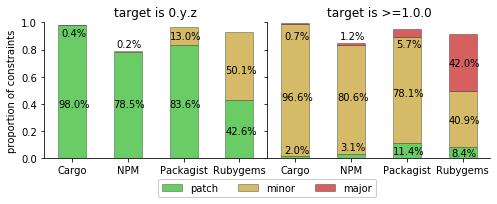

In [65]:
fig, axes = matplotlib.pyplot.subplots(
    ncols=2, 
    sharex=False, 
    sharey=True,
    gridspec_kw=dict(wspace=0)
)

fig.set_size_inches(FIG_SIZE_WIDE)

for i, kind in enumerate(['0.y.z', '>=1.0.0']):
    (
        data
        .xs(kind, level=1)
        [['patch', 'minor', 'major']]
        .plot.bar(stacked=True, color=PAL_REL[::-1], linewidth=1, edgecolor=(0, 0, 0, 0.3), legend=False, ax=axes[i])
    )
    
    axes[i].set(
        title='target is {}'.format(kind),
        xlabel='', 
        ylabel=''
    )
    axes[i].xaxis.set_tick_params(rotation=0)

positions = [
    ((0.40, 0.92), (0.06, 0.45, 0.90)),
    ((0.40, 0.84), (0.08, 0.45, 0.90)),
    ((0.40, 0.90), (0.05, 0.48, 0.84)),
    ((0.20, 0.65), (0.04, 0.28, 0.70)),
]
for i, ecosystem in enumerate(ECOSYSTEMS):
    for j, kind in enumerate(['0.y.z', '>=1.0.0']):
        for k, release in enumerate(['patch', 'minor', 'major']):
            value = data.loc[ecosystem, kind][release]
            if kind == '0.y.z' and release == 'major':
                continue
            axes[j].annotate('{:.1%}'.format(value), (i + 0.03, positions[i][j][k]), ha='center', va='center')
    
axes[0].legend(
    loc='lower center',
    ncol=3,
    bbox_to_anchor=(1, -0.32),
)

seaborn.despine(fig, top=True, right=True)

axes[0].set(
    xlabel='',
    ylabel='proportion of constraints',
    ylim=(0, 1),
)

savefig(fig, 'need_permissiveness')

In [66]:
data.T

ecosystem     Cargo                 NPM           Packagist            \
kind        >=1.0.0     0.y.z   >=1.0.0     0.y.z   >=1.0.0     0.y.z   
major      0.006985  0.000000  0.012305  0.000000  0.056669  0.000000   
minor      0.965914  0.003591  0.806013  0.001827  0.781270  0.129568   
patch      0.019744  0.980430  0.031203  0.785301  0.114474  0.836303   

ecosystem  Rubygems            
kind        >=1.0.0     0.y.z  
major      0.420105  0.000000  
minor      0.408818  0.500946  
patch      0.084002  0.426498

As expected, most dependencies (except in Rubygems) are "compliant with semver". That means that, in a situation where they make use of the latest major release of a target package, they will automatically benefit from the latest patch (for 0.y.z) and minor releases (for >=1.0.0).

## Releases being used by dependent packages

However, we expect that not all dependents make use of the latest major of a target package. Let's quantify how many dependents make use of: the latest release, a previous patch, a previous minor or a previous major.

## Induced technical lag

Relying on a previous version means that we "lag behind". We quantify this lag, in terms of time (difference between version used and latest version available) and in terms of versions (number of versions that were missed).

### Time-lag

### Version-lag

## Number of major releases used by dependent packages

Since many dependents make use of a previous major release, let's quantify, given a required package, the number of distinct major being used by dependent packages.

## Package reuse index

Since a package can have many distinct releases being used by dependent packages, we could propose a "package reuse index" whose goal is to quantify the number of these releases. There are two options there:

1) A variant of a Gini-index, measuring the inequality in terms of "release usage". The more "inequal" this usage is, the more "focused" are dependent packages. However, this does not allow to show whether the "focus" is on the latest major or not. 

2) A variant of the H-index, where n means there are n releases each being used by n dependent packages. 

### Variant of Gini-index

### Variant of H-index

# On the prevalence of backported updates

## Evolution of the number of packages with backports

## Evolution of the number of backports

## Relation between backports and dependents

We see whether there is relation between the presence of backports and the number of dependent packages.

## Relation between backports and used major

We see whether there is a relation between the presence of backports and the number of major releases being used.

# How and when are releases backported?

## Backport release type

The type of a backport depends on the "source" release (the one being backported) and the "target" release (the one being the backport). We expect that most backports correspond to patches being backported as patches, but it could be the case that some minor release has its fixes being backported as patch as well.

## Time and number of versions w.r.t. first `(N+1).x.x`

We expect that most backports are "quickly" released when a new major is available, in order to allow security or stability fixes to be available for dependents during their transition to the new major. 

## Time and number of versions w.r.t. first `(N).x.x`

Here we merely look at how long major versions are "supported". This aims to confirm that major releases having backports have more a "long-term support" than major releases without backports.

## Time and number of versions w.r.t. last (N).x.x

Same idea, but this time relatively to the latest (non-backported) release in the current branch.